In [1]:
import os
import io
import gpxpy
import folium
import selenium
import requests
import numpy as np
import pandas as pd
import sqlite3 as sq
import seaborn as sb
import osmnx as ox
import matplotlib.pyplot as plt


from PIL import Image
from ipywidgets import IntProgress
from scipy.stats import normaltest, shapiro, kstest, f_oneway
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
def parse_gpx(gpx_string, track_id):
    try:
        gpx = gpxpy.parse(gpx_string)
    except Exception as e:
        print(e)
        return None
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                            'track_id': track_id,
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'name': track.name
                        })
    return points

In [3]:
def length(parsed_gpx):
    length_3d = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            p1 = (track['latitude'][idx], track['longitude'][idx])
            p2 = (track['latitude'][idx + 1], track['longitude'][idx + 1])
            length_2d = geodesic(p1, p2).meters
            if pd.notna(track['elevation'][idx]):
                length_track = np.sqrt((length_2d ** 2) + (track['elevation'][idx] - track['elevation'][idx + 1]) ** 2)
            else:
                length_track = length_2d
            length_3d.append(length_track)
        length_3d.append(None)
    return length_3d

In [4]:
def time_delta(parsed_gpx):
    time_delta = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            time_delta.append(track['time'][idx + 1] - track['time'][idx])
        time_delta.append(None)
    return time_delta

In [5]:
def mean_day_temp(lat, lon, time):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
    	"latitude": lat,
    	"longitude": lon,
    	"start_date": time,
    	"end_date": time,
    	"daily": "temperature_2m_mean",
    }
    response = requests.get(url, params=params)
    return response.json()['daily']['temperature_2m_mean']

In [6]:
def temp_per_track(parsed_gpx):
    temp = {}
    for track in parsed_gpx.groupby('track_id'):
        track = track[1]
        if pd.notna(track['time']).sum():
            id = track.index[0]
            test = mean_day_temp(track['latitude'][id], track['longitude'][id], str(track['time'][id])[:10])
            temp[track['track_id'].mean()] = test[0]
        else:
            temp[track['track_id'].mean()] = None
    return temp

In [7]:
def parse_features(lat, lon, radius=500):
    point = (lat, lon)
    tags = {
        "water": {"natural": "water"},
        "forest": {"natural": "wood"},
        "buildings": {"building": True}
    }
    
    features = {}
    for key, tag in tags.items():
        try:
            gdf = ox.features.features_from_point(point, dist=radius, tags=tag)
            features[key] = len(gdf)
        except Exception as e:
            features[key] = 0
    
    return features

In [65]:
def get_features(parsed_gpx, n=3):
    bar = IntProgress(min=0, max=len(parsed_gpx.index))
    display(bar)
    water = []
    forest = []
    buildings = []
    features = parse_features(parsed_gpx['latitude'][0], parsed_gpx['longitude'][0])
    for idx in parsed_gpx.index:
        #if idx % n == 0:
            #features = parse_features(parsed_gpx['latitude'][idx], parsed_gpx['longitude'][idx])
        water.append(np.random.rand())
        forest.append(np.random.rand())
        buildings.append(np.random.rand())
        bar.value += 1
    return water, forest, buildings

In [66]:
def around_type(df):
    if pd.notna(df[['water', 'forest', 'buildings']]).sum() and df[['water', 'forest', 'buildings' ]].sum():
        if df['water'] + df['forest'] > 0:
            around = {'water': df['water'], 'forest': df['forest']}
            return max(around, key=around.get)
        if df['buildings'] > 0:
            return 'city'
    return None

In [76]:
class Agent:
    def __init__(self, path_to_db:str, path_to_maps:str):
        self.path_to_db = path_to_db
        self.path_to_maps = path_to_maps
        ox.settings.use_cache=True

    def save_data(self):
        try:
            conn = sq.connect(self.path_to_db)
            self.data.to_sql("data", con=conn, if_exists="replace", index=False)
            conn.close()
        except Exception as e:
            print(e)

    def parse_paths(self, paths):
        all_points = []
        trace_id = []
        self.idx = 0
        for path in paths:
            gpx = open(path, 'r')
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"Создан dataframe с {len(parsed_gpx['track_id'].unique())} маршрутами")
        self.data = parsed_gpx

    def add_gpx(self, gpx_strings:list[str]):
        all_points = []
        for gpx in gpx_strings:
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"В датасет добавлены {len(parsed_gpx['track_id'].unique())} маршрутов")
        self.data = pd.concat([self.data, parsed_gpx], ignore_index=True)

    def fill_dataset(self):
        parsed_gpx = self.data
        
        length_3d = length(parsed_gpx)
        parsed_gpx['length_3d'] = length_3d
        print("Посчитанны расстояния между точками")
    
        parsed_gpx['time_delta'] = time_delta(parsed_gpx)
        print("Просчитано время между точками")
        parsed_gpx['step_frequency'] = parsed_gpx.apply(lambda parsed_gpx: (parsed_gpx['length_3d'] / 0.75) / (parsed_gpx['time_delta'].total_seconds() + 0.01), axis=1)
        print("Просчитана частота шагов")
    
        temp = temp_per_track(parsed_gpx)
        parsed_gpx['tempurture'] = parsed_gpx['track_id'].map(lambda x: temp[x])
        print("Просчитана температура для каждого трека")

        n=14
        water, forest, buildings = get_features(parsed_gpx)
        parsed_gpx['water'] = water + [None] * (len(parsed_gpx) - len(water))
        parsed_gpx['forest'] = forest + [None] * (len(parsed_gpx) - len(forest))
        parsed_gpx['buildings'] = buildings + [None] * (len(parsed_gpx) - len(buildings))
        parsed_gpx['type'] = parsed_gpx.apply(around_type, axis=1)
        print(f'Посчитано количество обьектов вокруг каждой {n} точки')

        self.parse_country()
        print('Получены регионы для каждого маршрута')
        
        self.data = parsed_gpx

    def parse_country(self):
        country = []
        nom = Nominatim(user_agent='_')
        for track in self.data.groupby('track_id'):
            track = track[1]
            idx = track['track_id'].mean()
            location = nom.reverse(f'{track['latitude'].mean()}, {track['longitude'].mean()}')
            try:
                country.append(location.raw['address']['country'])
            except:
                country.append(None)
        self.data['country'] = self.data['track_id'].map(lambda x: country[x])

    def gen_img(self):
        for track in self.data.groupby('track_id'):
            track = track[1]
            idx = track['track_id'].mean()
            m = folium.Map(location=[track['latitude'].mean(), track['longitude'].mean()], zoom_start=12)
            folium.PolyLine(track[['latitude', 'longitude']].values).add_to(m)
            print(f"Карта маршрута {idx}")
            display(m)
            img_data = m._to_png(5)
            img = Image.open(io.BytesIO(img_data))
            img.save(os.path.join(self.path_to_maps, f'{idx}.png'))
        

# Создаём агента и указываем ему пути для сохранения данных

In [77]:
agent = Agent("data.db", "Maps/")
agent.parse_paths(['datasets/1.gpx', 'datasets/2.gpx', 'datasets/3.gpx', 'datasets/4.gpx'])

Создан dataframe с 4 маршрутами


In [78]:
gpx_data = pd.read_csv("datasets/gpx-tracks-from-hikr.org.csv")

In [79]:
agent.add_gpx(list(gpx_data['gpx'][:8]))

В датасет добавлены 8 маршрутов


In [80]:
agent.data

,track_id,latitude,longitude,elevation,time,name
0,0,46.988087,6.792303,1128.86,NaT,La Tourne - Vue des Alp - Genevey
1,0,46.988047,6.792166,1129.30,NaT,La Tourne - Vue des Alp - Genevey
2,0,46.989413,6.790911,1150.25,NaT,La Tourne - Vue des Alp - Genevey
3,0,46.990017,6.791000,1159.11,NaT,La Tourne - Vue des Alp - Genevey
4,0,46.990729,6.791723,1170.55,NaT,La Tourne - Vue des Alp - Genevey
...,...,...,...,...,...,...
1988,11,47.373334,7.539463,457.00,NaT,Bärschwil-Erschwil
1989,11,47.373791,7.541093,453.00,NaT,Bärschwil-Erschwil
1990,11,47.373207,7.541197,452.10,NaT,Bärschwil-Erschwil
1991,11,47.373188,7.541859,451.30,NaT,Bärschwil-Erschwil


# Дополняем датасет необходимыми признаками

In [82]:
agent.fill_dataset()

Посчитанны расстояния между точками
Просчитано время между точками
Просчитана частота шагов
Просчитана температура для каждого трека


IntProgress(value=0, max=1993)

Посчитано количество обьектов вокруг каждой 14 точки
Получены регионы для каждого маршрута


In [83]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

In [84]:
agent.data['time'] = pd.to_datetime(agent.data['time'])
agent.data['season'] = agent.data['time'].apply(get_season)
agent.data['hour'] = agent.data['time'].apply(lambda x: x.hour)

# Создаём карты с наложеными маршрутами

In [ ]:
agent.gen_img()

In [86]:
agent.save_data()

C:\Users\demoexam\AppData\Local\Temp\ipykernel_5740\3141753983.py:10: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  self.data.to_sql("data", con=conn, if_exists="replace", index=False)


In [85]:
agent.data.isnull().sum()

track_id            0
latitude            0
longitude           0
elevation           0
time              174
name                0
length_3d          12
time_delta        184
step_frequency    184
tempurture        174
water               0
forest              0
buildings           0
type                0
country             0
season              0
hour              174
dtype: int64

In [88]:
agent.data

,track_id,latitude,longitude,elevation,time,name,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings,type,country,season,hour
0,0,46.988087,6.792303,1128.86,NaT,La Tourne - Vue des Alp - Genevey,11.339566,NaT,NaN,NaN,0.621007,0.609204,0.958522,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
1,0,46.988047,6.792166,1129.30,NaT,La Tourne - Vue des Alp - Genevey,180.595312,NaT,NaN,NaN,0.280674,0.051561,0.131668,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
2,0,46.989413,6.790911,1150.25,NaT,La Tourne - Vue des Alp - Genevey,68.066622,NaT,NaN,NaN,0.827878,0.413342,0.119815,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
3,0,46.990017,6.791000,1159.11,NaT,La Tourne - Vue des Alp - Genevey,97.061687,NaT,NaN,NaN,0.995927,0.959644,0.578471,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
4,0,46.990729,6.791723,1170.55,NaT,La Tourne - Vue des Alp - Genevey,29.946428,NaT,NaN,NaN,0.990803,0.605543,0.212449,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,11,47.373334,7.539463,457.00,NaT,Bärschwil-Erschwil,133.209496,NaT,NaN,NaN,0.135208,0.899739,0.338343,forest,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
1989,11,47.373791,7.541093,453.00,NaT,Bärschwil-Erschwil,65.494368,NaT,NaN,NaN,0.971691,0.443479,0.576723,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
1990,11,47.373207,7.541197,452.10,NaT,Bärschwil-Erschwil,50.044645,NaT,NaN,NaN,0.781509,0.214409,0.423897,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN
1991,11,47.373188,7.541859,451.30,NaT,Bärschwil-Erschwil,66.867405,NaT,NaN,NaN,0.628699,0.551552,0.565951,water,Schweiz/Suisse/Svizzera/Svizra,Осень,NaN


# Описания признаков получившегося датасета

In [ ]:
describtions = pd.read_csv("describtions.csv")
describtions

# Статистика

## length_3d

In [ ]:
sb.histplot(agent.data['length_3d'], kde=True)

In [ ]:
res = normaltest(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = shapiro(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = kstest(agent.data['length_3d'], 'expon')
print(res.statistic)
print(res.pvalue)

## time_delta

In [ ]:
sb.histplot(agent.data['time_delta'].map(lambda x: x.seconds), kde=True)

In [ ]:
res = normaltest(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

In [ ]:
res = shapiro(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

In [ ]:
res = kstest(agent.data['time_delta'].map(lambda x: x.seconds), "expon")
print(res.statistic)
print(res.pvalue)

## tempurture

In [ ]:
sb.histplot(agent.data['tempurture'], kde=True)

In [ ]:
res = normaltest(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = shapiro(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

## step_frequency

In [ ]:
sb.histplot(agent.data['step_frequency'], kde=True)

In [ ]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = kstest(agent.data['step_frequency'], "expon")
print(res.statistic)
print(res.pvalue)

## type

In [ ]:
sb.histplot(agent.data['type'], kde=True)

Создание числового датасета

In [92]:
clean = agent.data.drop(['name', 'country', 'season'], axis=1)
clean = clean.dropna()
clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
clean['time_delta'] = clean['time_delta'].map(lambda x: x.seconds)
clean['time'] = clean['time'].map(lambda x: x.timestamp())

In [ ]:
res = normaltest(clean['type'])
print(res.statistic)
print(res.pvalue)

In [ ]:
res = shapiro(clean['type'])
print(res.statistic)
print(res.pvalue)

# Анализ значимых атрибутов

In [ ]:
cor = clean.corr()
sb.heatmap(cor)
plt.show()

In [ ]:
groups = [group['type'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['latitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['longitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['time'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['length_3d'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['elevation'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['forest'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

### Анализ атрибутов показал, что признаки ('type', 'latitude', 'longitude', 'time', 'length_3d', 'elevation', 'forest') в датасете сильно влияют на схожесть групп

## Проводим кластеризацию используя значимые атрибуты

In [93]:
X_scaled = StandardScaler().fit_transform(pd.get_dummies(clean))
pca = PCA().fit(X_scaled)
x = np.arange(1, )

C:\Users\demoexam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


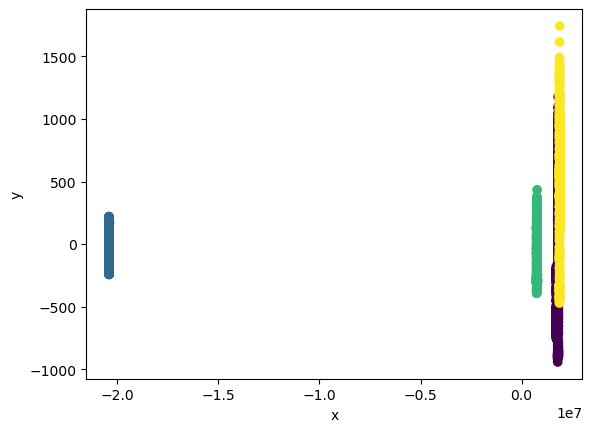

In [94]:
pca = PCA(n_components=2)
class_data = clean
data_2d = pca.fit_transform(class_data)
dbscan = KMeans(n_clusters=4)
dbscan.fit(data_2d)
labels = dbscan.predict(data_2d)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Добавляем получившееся каластеры в датасет и сохраняем в БД

In [95]:
clean['cluster'] = labels

In [96]:
try:
    conn = sq.connect("data.db")
    clean.to_sql("clean", con=conn, if_exists="replace", index=False)
    conn.close()
except Exception as e:
    print(e)

In [46]:
sb.scatterplot(data=clean, x='season', y='latitude', hue='cluster')

ValueError: Could not interpret value `season` for `x`. An entry with this name does not appear in `data`.